## Objective

Background

Your company owns a chain of stores across Russia that sell a variety of types of alcohol. The company recently ran a wine promotion in Saint Petersburg that was very successful. Due to the cost to the business, it isn’t possible to run the promotion in all regions. The marketing team would like to target 10 other regions that have similar buying habits to Saint Petersburg where they would expect the promotion to be similarly successful.

Challenge

- Recommend 10 additional regions they should select for the promotion.

## Importing Libraries

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

Open your csv and check which variables we are working on

In [61]:
df = pd.read_csv('russian_alcohol_consumption.csv')
df.head()

,year,region,wine,beer,vodka,champagne,brandy
0,1998,Republic of Adygea,1.9,8.8,3.4,0.3,0.1
1,1998,Altai Krai,3.3,19.2,11.3,1.1,0.1
2,1998,Amur Oblast,2.1,21.2,17.3,0.7,0.4
3,1998,Arkhangelsk Oblast,4.3,10.6,11.7,0.4,0.3
4,1998,Astrakhan Oblast,2.9,18.0,9.5,0.8,0.2


It's very useful if you could check brief description about the numerical variables in the dataset

In [176]:
df.describe()

,year,wine,beer,vodka,champagne,brandy
count,1549.000000,1549.000000,1549.000000,1549.000000,1549.000000,1549.000000
mean,2007.019367,5.638528,51.517205,11.854939,1.315526,0.526998
std,5.489208,2.806004,25.183890,5.097104,0.796938,0.400201
min,1998.000000,0.100000,1.000000,0.400000,0.100000,0.000000
25%,2002.000000,3.600000,32.600000,8.400000,0.800000,0.200000
50%,2007.000000,5.400000,50.100000,11.500000,1.200000,0.400000
75%,2012.000000,7.400000,67.500000,15.000000,1.680000,0.700000
max,2016.000000,18.100000,207.300000,40.600000,5.560000,2.300000


We can conclude, for example, that in average Beer is is the most consumed beverage and brandy is the lower one.

But much more.

Other thing that you should always do is remove na values from your dataset

In [180]:
df.dropna(inplace = True)

Let's add a total consumption of alcohol per capita to check variations over the years and have a better interpretation about the total

consumption per capita of all beverages in Russia.

In [3]:
df['total_consumption'] = df['wine'] + df['beer'] + df['vodka'] + df['champagne'] + df['brandy']
df.head()

,year,region,wine,beer,vodka,champagne,brandy,total_consumption
0,1998,Republic of Adygea,1.9,8.8,3.4,0.3,0.1,14.5
1,1998,Altai Krai,3.3,19.2,11.3,1.1,0.1,35.0
2,1998,Amur Oblast,2.1,21.2,17.3,0.7,0.4,41.7
3,1998,Arkhangelsk Oblast,4.3,10.6,11.7,0.4,0.3,27.3
4,1998,Astrakhan Oblast,2.9,18.0,9.5,0.8,0.2,31.4


Let's plot side by side the evolution over the years of the total consumption and per beverage.

- We will try to confirm that beer is the most consumed beverage.

- We will check if the consumption is increasing, decreasing or stationary over the years.

- If some of the beverages with lower consumption are having an increasing in consumption over the years.

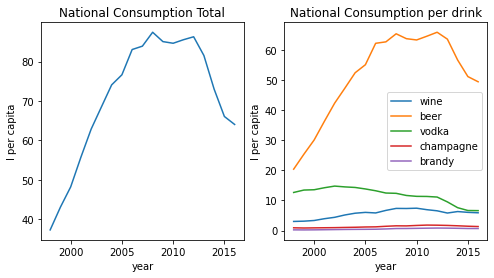

In [5]:
list = ['wine','beer','vodka','champagne','brandy']
fig, (ax1, ax2) = plt.subplots(1,2, figsize= (8,4))
sns.lineplot(x = 'year', y = 'total_consumption', data = df, ax = ax1, ci = None)
for i in list:
    sns.lineplot(x = 'year', y = df[i], data = df, ax = ax2, ci = None)
ax1.set_title('National Consumption Total')
ax1.set_ylabel('l per capita')
ax2.set_title('National Consumption per drink')
ax2.legend(labels = list)
ax2.set_ylabel('l per capita')
plt.show()

We can conclude that nationally,

- Beer is by far the most consumed beverage in Russian but its consumption is decreasing since around 2010.

- National consumption increased until around 2010 and then decreased. National Consumption is higly impacted by beer consumption.

- Wine is the only beer that has been increasing over the years.

After doing a National overview, let's check St. Petersburg Case

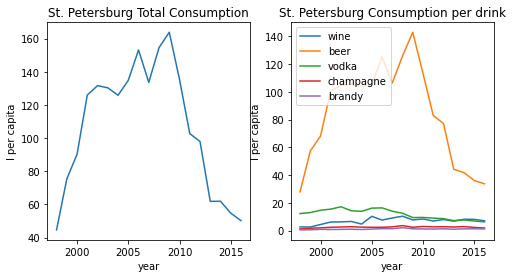

In [6]:
st_peter = df[df['region'] == 'Saint Petersburg']
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(8,4))
sns.lineplot(x = 'year', y = 'total_consumption', data = st_peter, ax = ax1)
for i in list:
    sns.lineplot(x = 'year', y = df[i], data = st_peter, ax = ax2, ci = None)
ax1.set_title('St. Petersburg Total Consumption')
ax1.set_ylabel('l per capita')
ax2.set_title('St. Petersburg Consumption per drink')
ax2.legend(labels = list, loc = 'upper left')
ax2.set_ylabel('l per capita')
plt.show()

We can conclude that in St. Petersburg case,

- The trend is similar than in National Case, but more extreme.

- Consumption of alcohol is similar in 1995 & 2015.

- Beer is by far the most consumed beverage in St. Petersburg.

Additionally, and for curiosity, let's verify if we have a moderate to strong correlation between two different beverages.

Meaning that the ones that drink some beverage drink other too.

<AxesSubplot:>

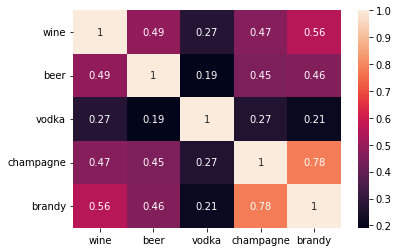

In [7]:
correlation = df[list].corr()
sns.heatmap(correlation, annot = True)

We have a positive correlation between all beverages.

However the correlation between Champagne & Brandy are strong enough to suppose that the people who drinks champagne drink Brandy too.

Note: This two are the beverages with the lowest consumption.

<AxesSubplot:xlabel='champagne', ylabel='brandy'>

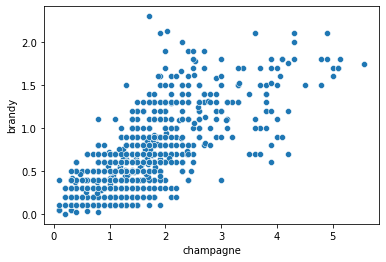

In [181]:
sns.scatterplot(x ='champagne', y = 'brandy', data = df)

## Cluster Analysis

The Objective of this project is to find the closest 10 neighbours (countries) of St. Petersburg we will perform a cluster analysis and 

afterwards a kmeans with the number of clusters that we chose.

## Step 1 - will work on our dataset to be able to feed it to the model

In [183]:
#Passing the DataFrame from wide to long, meaning that the alcohol columns will be in just one column.
df_long = pd.melt(df, id_vars = ("region", "year"), value_vars = list, var_name = "alcohol", 
                  value_name = "consumption per capita in litre")

#Calculate mean, max, min, median and std, per region and alcohol. Note we will drop year column and groupby the dataset per region 
# and alcohol, and calculate all the characteristics for every single beverage in every single year.
df_region = df_long.drop(columns='year').groupby(['region','alcohol']).agg([np.mean,np.max,np.min,np.median,np.std])

#We will remove the index of the total consumption cause we don't need, however if the question was for total consumption without
#knowing or wanting the consumption for every single beverage we should work with that one.
df_region.columns = df_region.columns.droplevel(0)

#We must reset the index before we unpivot the the columns that we will work on.
df_region = df_region.reset_index()

#Pivot the dataset where region is in the index and alcohol features in the columns. It can be the other way around if you want.
df_region = df_region.pivot(index = "region", 
                                  columns = "alcohol")

#Usually it's a pass that I don't do however it makes sense to do it for the model be able to identify metrics.
#If you want you can change amax and amin to min or max, we will let it be.
df_region.columns = df_region.columns.map('_'.join)
df_region

,mean_beer,mean_brandy,mean_champagne,mean_vodka,mean_wine,amax_beer,amax_brandy,amax_champagne,amax_vodka,amax_wine,...,median_beer,median_brandy,median_champagne,median_vodka,median_wine,std_beer,std_brandy,std_champagne,std_vodka,std_wine
region,,,,,,,,,,,,,,,,,,,,,
Altai Krai,48.373158,0.236842,1.207368,9.465789,3.174211,70.40,0.40,1.54,14.2,4.80,...,51.6,0.20,1.2,9.9,3.3,13.259329,0.116479,0.225409,2.620541,1.154303
Altai Republic,36.724211,0.253684,0.934737,9.683684,5.190000,62.90,0.52,1.40,11.7,6.70,...,39.0,0.30,1.0,9.9,5.4,18.674874,0.159451,0.221695,1.262164,0.911903
Amur Oblast,53.377368,0.396842,1.115789,14.216842,5.221579,83.27,0.70,1.90,20.8,7.60,...,50.7,0.40,1.0,15.8,5.8,19.580882,0.183698,0.512362,4.387590,1.802024
Arkhangelsk Oblast,47.036842,0.870526,1.631053,17.381053,8.670000,109.00,1.30,2.60,31.9,12.23,...,45.6,0.90,1.6,16.2,9.0,20.868057,0.311724,0.612907,5.492676,2.294363
Astrakhan Oblast,54.695263,0.361053,0.861579,9.296842,4.469474,79.70,0.70,1.10,12.9,6.10,...,59.8,0.30,0.9,9.5,4.5,19.833411,0.214318,0.144694,2.383315,0.763715
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Vologda Oblast,67.206842,0.517895,0.857368,17.217895,9.328421,108.60,0.80,1.30,26.7,18.10,...,84.8,0.60,0.8,17.4,9.4,26.665173,0.187604,0.350996,4.930864,3.638042
Voronezh Oblast,54.911053,0.402105,1.500000,9.916316,4.637895,85.20,0.60,2.30,14.2,7.50,...,51.1,0.44,1.4,10.5,4.7,21.538209,0.176622,0.338296,3.060638,1.807686
Yamalo-Nenets Autonomous Okrug,80.137895,0.951579,1.485789,15.093158,5.312105,106.60,1.80,2.53,23.3,7.70,...,87.4,1.10,1.7,14.1,5.0,25.089080,0.543336,0.668625,4.163132,1.334544


## Step 2 - Rescaling Data.

It's almost need everytime to standardize the data for this to be more or less similar to a normal distribution.

In [185]:
scalar = StandardScaler()
#Standardizing the Data into arrays
df_region_scalar = scalar.fit_transform(df_region)
#Passing the standardizing data to a dataframe again
df_region_std = pd.DataFrame(df_region_scalar, index = df_region.index, columns = df_region.columns)
df_region_std.shape

(84, 25)

When you print the shap of our standardized dataset you will have,

- 84 number of samples.

- 25 number of features.

df_region_std will be feed to fit_transform() to apply a dimensional reduction.

## Step 3 - Final Analysis

- 3.1 - Dimensional transformation to the dataset.
- 3.2 - Choose the number of clusters to run the kmeans.
- 3.3 - Inertia Kmeans

-----------------------
- 3.1 - Dimensional transformation to the dataset.

In [112]:
pca = PCA()
pca_array = pca.fit_transform(df_region_std)
pca_array

array([[-3.21631632e+00,  2.60555391e-01, -1.32300453e+00, ...,
        -5.04995763e-03,  7.01520195e-02,  1.27230795e-02],
       [-2.94107638e+00,  4.97794747e-01,  4.59651960e-01, ...,
        -6.27304696e-02, -8.65679473e-02, -1.42733440e-02],
       [-1.85290624e-01, -1.14651983e+00, -2.74614085e-01, ...,
        -8.86159112e-02, -2.04472213e-02,  7.61875028e-02],
       ...,
       [ 3.87486099e+00,  3.28051612e-01, -1.74722393e+00, ...,
        -7.23190630e-03, -1.00828574e-02,  1.87186430e-02],
       [ 2.22167526e+00, -1.68887296e+00,  2.70791722e-01, ...,
        -3.76338741e-02, -1.35156107e-02,  2.16237062e-02],
       [ 4.49730987e+00, -6.41686941e+00, -3.09547260e-01, ...,
        -8.59198676e-02,  2.38352649e-02, -1.04355890e-02]])

-----------------------------
- 3.2 - Choose the number of clusters to run the kmeans.

Note: 

- Avoid using too many clusters in the analysis, will not be able to group the data with satisfactory variance and the analysis will take too much time. 

- Try to use 3 or 4 clusters were the explained variance is above 75%. If not go for 5 or 6.

In [192]:
print(f'''With 3 clusters we have a explained variance of {np.sum(pca.explained_variance_ratio_[:4])} and with 4 clusters we have a explained variance of {np.sum(pca.explained_variance_ratio_[:3])}''')

With 3 clusters we have a explained variance of 0.7937780778236211 and with 4 clusters we have a explained variance of 0.7097093913566116


Looking to the results of explained variance that we obtain and as I said I prefer to work with explained variance over 75% he will perform our analysis with 4 clusters. 

 ------------------------
 - Step 3.3 - Inertia kmeans

Let's build the dataset with the 4 PCA Features.

We will append the first 4 values in our dimensional values obtained in the PCA above to a dataset with the countries.

This four clusters will be used to group regions for similarity ahead.

In [115]:
pca_df = pd.DataFrame({i+1: pca_array[:, i] for i in range(4)}, index=df_region_std.index)
pca_df

,1,2,3,4
region,,,,
Altai Krai,-3.216316,0.260555,-1.323005,0.475485
Altai Republic,-2.941076,0.497795,0.459652,-0.305172
Amur Oblast,-0.185291,-1.146520,-0.274614,0.698728
Arkhangelsk Oblast,4.295602,-0.840900,1.772732,0.529319
Astrakhan Oblast,-2.582756,-0.128260,-1.380465,-0.243217
...,...,...,...,...
Vologda Oblast,2.841449,-4.667691,0.641423,-1.929784
Voronezh Oblast,-1.270769,-0.014235,-1.098456,0.259602
Yamalo-Nenets Autonomous Okrug,3.874861,0.328052,-1.747224,1.370767


Optional we can calculate the inertia

Inertia is used to calculate the distance between every point to their centroid.

In [170]:
# from sklearn.cluster import KMeans
# #We will consider for this plot what literature usually says between 2 to 10 features
# cluster_num = np.arange(2,11) 
# inertia_list = []

# for num in cluster_num:
#     kmeans = KMeans(n_clusters = num, random_state = 3, max_iter = 10000, algorithm="full")
#     kmeans.fit(pca_df)
#     inertia_list.append(kmeans.inertia_)
# inertia_list

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting

[1069.8509122633382,
 845.7336127286051,
 714.0693959071203,
 650.5817511033307,
 553.978490304276,
 494.63043711123163,
 455.03072860611513,
 408.1501972462134,
 366.88083247211006]

## Step 5 - KMeans with 4 clusters

Before running our kmeans we will build the DataFrame to feed our KMeans Analysis.

We will append the first 4 values (correspondent to the 4 clusters that we chose) and append the 25 features that they have.

In [199]:
pca_component_df = pd.DataFrame(pca.components_[:4], index=[f"feature_{i}" for i in range(1, 5)], columns = df_region_std.columns)
pca_component_df

,mean_beer,mean_brandy,mean_champagne,mean_vodka,mean_wine,amax_beer,amax_brandy,amax_champagne,amax_vodka,amax_wine,...,median_beer,median_brandy,median_champagne,median_vodka,median_wine,std_beer,std_brandy,std_champagne,std_vodka,std_wine
feature_1,0.175428,0.247475,0.236902,0.253246,0.217676,0.162063,0.253313,0.244957,0.226201,0.179077,...,0.170584,0.236051,0.240948,0.243306,0.201791,0.128194,0.240484,0.207818,0.123960,0.113789
feature_2,-0.192833,0.232658,0.238262,-0.138610,-0.110735,-0.274479,0.136853,0.138882,-0.187639,-0.237334,...,-0.174729,0.220720,0.227620,-0.146341,-0.122641,-0.270426,0.090797,0.016130,-0.176319,-0.300835
feature_3,-0.400981,0.040883,-0.087718,0.053389,0.203603,-0.320756,0.097614,0.036259,0.033962,0.238102,...,-0.391899,0.020680,-0.124140,0.053806,0.241396,-0.278992,0.194644,0.164043,-0.045556,0.278009
feature_4,-0.100073,0.019885,0.037757,0.116164,-0.349297,0.051199,0.084704,0.166135,0.269101,-0.271551,...,-0.111987,0.085063,0.028615,0.077637,-0.353270,0.151740,0.140719,0.276904,0.359633,-0.193074


To define KMeans, we should feed,

- n_clusters - N_clusters defined, this case 4.

- random_state - Make the results reproducible, and if you define an seed as int it will present always the same result.

- max_iter - Usually I go with 1000, lower iteractions will make your model with low efficiency and higher iterations memory and time consumption it's a problem.

- algorithm - we chose full that is a lloyd variation.

In [130]:
#Kmeans for 4 clusters
kmeans_4 = KMeans(n_clusters = 4, random_state = 1, max_iter = 1000, algorithm="full")

#Fit the pca_df to the data
kmeans_4.fit(pca_df)

#Labeling regions with the cluster that we obtained.
df_by_region["cluster"] = kmeans_4.labels_
pca_df["cluster"] = kmeans_4.labels_

#We want to check what was the cluster for St. Petersburg
st_peter_cluster = int(pca_df.query("region == 'Saint Petersburg")["cluster"].values)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


## Will we have 10 region in the same clusteer of St. Petersburg ?

To simplify the method, we wil check if we have at least 10 regions in the St. Petersburg cluster.

If so, we only we work with this one.

In [159]:
# Regions that belong to the ST.Petersburg Cluster
df_same_cluster = pca_df.query("cluster == @st_peter_cluster")
len(df_same_cluster)

17

So we have 17 regions in cluster number 3 the one with St.Petersburg.

So, we will only calculate the distance for the 16 regions to St. Petersburg.

First thing is to find St.Petersburg Coordinates and next proceed to the Euclidean Distance.

In [206]:

st_peter_x, st_peter_y = df_same_cluster.query("region == 'Saint Petersburg'")[[1, 2]].values.flatten()
distance_array = []

#Iterate over the 16 rows left with (x,y) coordinates
for x, y in zip(df_same_cluster[1], df_same_cluster[2]):
    distance = (x-st_peter_x)**2 + (y-st_peter_y)**2
    distance_array.append(distance)   
df_same_cluster["distance"] = np.array(distance_array)

C:\Users\alvar\AppData\Local\Temp/ipykernel_16408/2065577188.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_same_cluster["distance"] = np.array(distance_array)


In [207]:
# Getting the 10 most similar regions to Saint Petersburg
df_same_cluster.sort_values(by="distance", ascending=True, inplace=True)
df_same_cluster[:11]

C:\ProgramData\Anaconda3\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


,1,2,3,4,cluster,distance
region,,,,,,
Saint Petersburg,5.479529,0.932415,-3.203642,-0.613288,3,0.000000
Sakhalin Oblast,5.082722,0.556565,2.012486,2.670133,3,0.298719
Leningrad Oblast,5.152411,0.430419,1.408669,0.973746,3,0.359006
Nenets Autonomous Okrug,6.277883,-0.155404,2.543594,1.679626,3,1.820717
Moscow Oblast,4.397366,-0.232296,0.117114,1.939301,3,2.527628
Kaliningrad Oblast,3.948914,0.279488,1.496405,-0.767593,3,2.769096
Yamalo-Nenets Autonomous Okrug,3.874861,0.328052,-1.747224,1.370767,3,2.940215
Khanty–Mansi Autonomous Okrug – Yugra,3.437430,0.468836,-1.339845,1.218267,3,4.385074
Khabarovsk Krai,3.403460,0.525254,-1.700552,1.212698,3,4.475844


## Conclusion

Looking to our Final DataSet we go with the firs ten after St.Petersburg values

In [218]:
[i for i in df_same_cluster.index[:11]]

['Saint Petersburg',
 'Sakhalin Oblast',
 'Leningrad Oblast',
 'Nenets Autonomous Okrug',
 'Moscow Oblast',
 'Kaliningrad Oblast',
 'Yamalo-Nenets Autonomous Okrug',
 'Khanty–Mansi Autonomous Okrug – Yugra',
 'Khabarovsk Krai',
 'Arkhangelsk Oblast',
 'Murmansk Oblast']